In [1]:
import matplotlib.pyplot as plt 
import numpy as np
import japanize_matplotlib
import time
# from pathlib import Path
# BASE_DIR = Path(__file__).resolve().parent.parent.parent

# 5資産の期待収益率、相関係数、標準偏差、無リスク資産リターンに変更があれば更新する
sisan=["国内債券","国内株式","先進国債券","先進国株式","新興国株式"] # 資産の種類定義
r=[1.00,4.80,3.50,5.00,9.25] # 期待収益率
rho=[[1,0.16,-0.06,-0.05,-0.29],
    [0.16,1,-0.25,0.27,0.73],
    [-0.06,-0.25,1,0.56,0.11],
    [-0.05,0.27,0.56,1,0.91],
    [-0.29,0.73,0.11,0.91,1]] # 相関係数行列
sigma=[5.4,22.15,13.25,19.59,26.25] # 標準偏差

# 期待収益率関数の定義
def EST_PF_Return(fx,n):
    PF_Return=0
    for i in range(0,n):
        PF_Return+=r[i]*fx[i]
    
    return PF_Return

# 標準偏差関数の定義
def EST_PF_Sigma(fx,n):
    PF_Sigma=0
    for i in range(0,n):
        for j in range(0,n):
            PF_Sigma+=rho[i][j]*sigma[i]*sigma[j]*fx[i]*fx[j]
            
    PF_Sigma=np.sqrt(PF_Sigma)
    return PF_Sigma

In [2]:
def portfolio_cal(x_now):
    # 期待収益率、標準偏差の計算
    n=len(sisan)
    r_now=EST_PF_Return(x_now,n)
    sigma_now=EST_PF_Sigma(x_now,n)

    # 条件設定
    nmax=15 #投 資比率の精度
    r_nonrisk=0

    # 文字の定義
    m=0 # 全体の計算回数
    
    x=[0]*n # 資産の比率を表す配列の器の設定
    return_risk=[r_nonrisk]*(nmax**4) # リスク資産のリターン
    sigma_risk=[0]*(nmax**4)  # リスク資産の標準偏差
    xx0=[0]*(nmax**4)         # 資産配分比率
    xx1=[0]*(nmax**4)
    xx2=[0]*(nmax**4)
    xx3=[0]*(nmax**4)
    xx4=[0]*(nmax**4)
    xmin=[0]*n # xは更新されてしまうので別で保存
    sigmap_min=1000000 # 適当に大きい数値を設定
    err=1e-6 # 許容する誤差

    r_low=2  # リターン2%以上の効率的ポートフォリオを計算
    r_high=8+1 # リターン8%以下の効率的ポートフォリオを計算
    n_efficient=5 # 1%を何分割で計算するか

    # 資産配分の組み合わせを作成
    for x0 in range(0,nmax):
        x[0]=x0/nmax
        for x1 in range(0,nmax):
            x[1]=x1/nmax
            count=x[0]+x[1]
            if count>1+err: # 投資比率が100%を超えた時
                break       # 内側のforを抜ける
            for x2 in range(0,nmax):
                x[2]=x2/nmax
                count=x[0]+x[1]+x[2]
                if count>1+err: # 投資比率が100%を超えた時
                    break       # 内側のforを抜ける
                for x3 in range(0,nmax):
                    x[3]=x3/nmax
                    count=x[0]+x[1]+x[2]+x[3]
                    if count>1+err: # 投資比率が100%を超えた時
                        break       # 内側のforを抜ける
                    x[4]=round(1-count,6)

                    # 期待収益率の計算
                    rp=EST_PF_Return(x,n) # 関数の使用
                    return_risk[m]=rp # リターンの記録

                    sigmap=EST_PF_Sigma(x,n) # 関数の使用
                    sigma_risk[m]=sigmap # リスクの記録

                    xx0[m]=x[0] # 資産配分の記録
                    xx1[m]=x[1] # 資産配分の記録                
                    xx2[m]=x[2] # 資産配分の記録                
                    xx3[m]=x[3] # 資産配分の記録                
                    xx4[m]=x[4] # 資産配分の記録   

                    m=m+1 # 計算回数の更新

    # Full Investmentの計算
    sigma_full=[0]*(nmax**4) 
    return_full=[0]*(nmax**4)
    xx0_full=[0]*(nmax**4)
    xx1_full=[0]*(nmax**4)
    xx2_full=[0]*(nmax**4)
    xx3_full=[0]*(nmax**4)
    xx4_full=[0]*(nmax**4)           

    for j in range (0,nmax**4-1): # 全データを調査
        if xx0[j]==0 and xx2[j]==0: # Full Ivestmentの条件判定
                sigma_full[j]=sigma_risk[j]
                return_full[j]=return_risk[j]
                xx0_full[j]=xx0[j]
                xx1_full[j]=xx1[j]
                xx2_full[j]=xx2[j]
                xx3_full[j]=xx3[j]
                xx4_full[j]=xx4[j]

    # Full Investmentの効率的ポートフォリオの計算
    sigma_min_full=[999]*((n_efficient)*(r_high-r_low)+1)
    return_min_full=[r_nonrisk]*((n_efficient)*(r_high-r_low)+1)
    xx0_min_full=[0]*((n_efficient)*(r_high-r_low)+1)
    xx1_min_full=[0]*((n_efficient)*(r_high-r_low)+1)
    xx2_min_full=[0]*((n_efficient)*(r_high-r_low)+1)
    xx3_min_full=[0]*((n_efficient)*(r_high-r_low)+1)
    xx4_min_full=[0]*((n_efficient)*(r_high-r_low)+1)

    for j in range(r_low*n_efficient,r_high*n_efficient+1):
        k=j-r_low*n_efficient
        l=j/n_efficient
        for i in range(0,nmax**4-1): # 全データを調査
            if sigma_min_full[k]>sigma_full[i] and return_full[i]>=l:
                sigma_min_full[k]=sigma_full[i] # より小さい値に更新
                return_min_full[k]=return_full[i]
                xx0_min_full[k]=xx0[i]
                xx1_min_full[k]=xx1[i]
                xx2_min_full[k]=xx2[i]
                xx3_min_full[k]=xx3[i]
                xx4_min_full[k]=xx4[i]

    # グラフ化
    plt.rcParams['figure.subplot.bottom'] = 0.2
    plt.rcParams['figure.subplot.top'] = 0.9
    plt.figure(figsize=(10,3.5))
    print('sigma_risk',len(sigma_risk))
    print('retirm_risk',len(return_risk))

    plt.scatter(sigma_risk,return_risk,c='green',label='Stocks and Bonds', alpha=0.3) 

    plt.scatter(sigma_full,return_full,c='red',label='Stocks only', alpha=0.5)
    
    plt.scatter(sigma, r, color='black',s=100)
    for num,i in enumerate(sisan):
        plt.text(sigma[num], r[num]-1, i, fontsize=11)

    plt.scatter(sigma_now,r_now,c='blue',label='入力した条件',s=100)

    plt.legend(loc='upper left',fontsize=12)
    plt.xlabel("Risk(%)",fontsize=12) 
    plt.ylabel("Return(%)",fontsize=12) 
    plt.xlim(4,30)
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=12)
#     plt.savefig(str(BASE_DIR)+'/static/images/portfolio_calculate.png')
    plt.show()
    plt.clf()
    plt.close()
    return

sigma_risk 50625
retirm_risk 50625


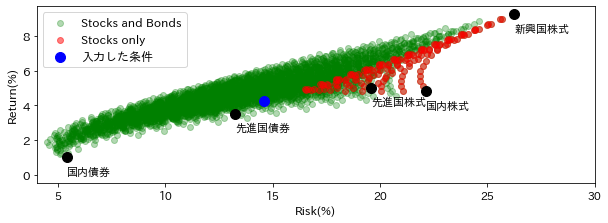

In [3]:
x_now = [0,0,0.5,0.5,0]
portfolio_cal(x_now)